# Date Selection
This notebook allows to plot average `precipitation` and `temperature` over the Lombardy region for a given month of the year.

Because geospatial data on the areas of manure spreading are not available, it is necessary to identify a criterion to choose the most likely periods when, on average, such practices are carried out. The choice of these periods was made precisely on the basis of temperature, rainfall and the main months in which fertilization in Lombardy region takes place (e.g. march/april).

The data used come from [meteorological stations operated by ARPA Lombardy](https://www.dati.lombardia.it/Ambiente/stazioni-meteo/pevf-9zqp).
In order to access to these data using the Socrata API, you must register to [Open Data Regione Lombardia](https://www.dati.lombardia.it/). The [sodapy](https://github.com/xmunoz/sodapy) library allows to request the data using this API.

## Import libraries

In [1]:
#Warnings
import warnings
warnings.filterwarnings('ignore')

#Main libraries
from sodapy import Socrata
import pandas as pd
import geopandas as gpd
import os
import zipfile
import requests
import json
import io
from scipy import stats
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set current working directory
cwd = os.getcwd()

# Import functions defined for DDUST project:
from functions import DDUST_methods

# Key and app token for Socrata API
f = open('keys.json')
keys = json.load(f)

## Define time range
First, is possible to select a `month` and a `year`:

In [2]:
month = 10  #eg. 3 corresponds to March
year = 2021
start_date_dt = datetime(year, month, 1).date()
print(start_date_dt)

2021-10-01


Then we can set a function that gets the last day of the given month:

In [3]:
# Function to get the last day of the month
def last_day_month(test_date):            
    # getting next month
    # using replace to get to last day + offset
    # to reach next month
    nxt_mnth = test_date.replace(day=28) + timedelta(days=4)

    # subtracting the days from next month date to
    # get last date of current Month
    res = nxt_mnth - timedelta(days=nxt_mnth.day)

    return res

Now we can visualize the start and the end days for the selected month:

In [4]:
# Start and end days of the month
start_date = str(start_date_dt)
end_date = str(last_day_month(start_date_dt))[0:10]
end_date_dt = datetime.strptime(end_date, '%Y-%m-%d') + timedelta(days=1)
print('The time range is '+start_date + ' - ' + end_date)

The time range is 2021-10-01 - 2021-10-31


## Get ARPA meteorological sensors information

Let's now connect to ARPA [Socrata API](https://dev.socrata.com/), which allows to require all the information associated to the meteorological stations (e.g. name, sensor type, station id, location etc.).

<div class="alert alert-warning" role="alert">
<span>&#9888;</span>
<a id='warning'></a> Remember that is required to register to Open Data Regione Lombardia in order to get access to these data.
</div>

In [5]:
arpa_domain = "www.dati.lombardia.it"
m_st_descr = "nf78-nj6b"
client = Socrata(arpa_domain, app_token = keys['arpa_token'])
results = client.get_all(m_st_descr)
meteo_st_descr = pd.DataFrame(results)
meteo_st_descr["idsensore"] = meteo_st_descr["idsensore"].astype(int)

## Get ARPA meteorological sensors times series

It's now possible to effectively request the time series for each meteorological sensor.

It's important to remember that is possible to request data directly from the API for the current year only, while if data from previous years are needed you must download the `.zip` folder containing the time series in `.csv` format.

The following code will automatically request data from the Socrata API, by checking the year selected at the beginning of the notebook. The link for downloading the `.zip` folder for multiple years is available inside `DDUST_methods` within the `meteo_sensor` function.

Moreover, if the `.zip` folder of the selected year is already available inside the current working directory, it won't be downloaded again.

In [9]:
# If current year use data from API
if int(year) == datetime.today().year:
    arpa_domain = "www.dati.lombardia.it"
    dati = "647i-nhxk" #change this depending on the dataset (check Open Data Lombardia datasets)
    client = Socrata(arpa_domain, app_token = keys['arpa_token']) #insert your arpa_token
    date_query = "data > {} and data < {}".format('"'+ start_date + '"','"'+ str(end_date_dt) + '"')
    results = client.get(dati, where=date_query, limit=5000000000000)
    meteo_data = pd.DataFrame(results)
    meteo_data.rename(columns={'IdSensore': 'idsensore','Data': 'data','idOperatore': 'idoperatore','Stato': 'stato','Valore': 'valore'}, inplace=True)
    meteo_data['data'] =  pd.to_datetime(meteo_data['data'], format='%Y/%m/%d %H:%M:%S')
    meteo_data = meteo_data.astype({"idsensore": int,"valore": float})
    
# If previous years download the corresponding year .csv file and filter the dates  
elif int(year) < datetime.today().year:
    filename = 'meteo_'+str(year)+'.zip'
    if not os.path.exists(os.path.join(filename)):
        csv_url = my_methods.meteo_sensor(str(year))
        r2 = requests.get(csv_url, allow_redirects=True)
        DL_zip = open(filename, 'wb').write(r2.content)
        print('Dowloaded zip file')
    
    print('Zip file exist')
    archive = zipfile.ZipFile(filename, 'r')
    data = archive.open(str(year)+'.csv') 
    meteo_data_df = pd.read_csv(data, dtype={"IdSensore": int,"Valore": float, "Stato": str, "idOperatore":str})
    meteo_data_df.rename(columns={'IdSensore': 'idsensore','Data': 'data','idOperatore': 'idoperatore','Stato': 'stato','Valore': 'valore'}, inplace=True)
    meteo_data_df['data'] =  pd.to_datetime(meteo_data_df['data'], format='%d/%m/%Y %H:%M:%S')

Zip file exist


While for current year data is possible to apply a filter directly the API request, for `.csv` yearly time-series is necessary to apply a mask the whole dataset loaded in meteo_data_df dataframe. Changing the time period is possible to filter the data and

In [12]:
# Keep meteo_data_df in memory for .csv files only. It's possible to create a new meteo_data dataframe changing the time period
mask = (meteo_data_df.data >= start_date) & (meteo_data_df.data < str(end_date_dt))
meteo_data = meteo_data_df.loc[mask]

## Meteorological sensors data processing

Now that the we have all the meteorological data inside the given time range, is possible to remove unused columns and NaN (with value -9999):

In [9]:
meteo_data = meteo_data.drop(columns=['stato', 'idoperatore'])
meteo_data = meteo_data[meteo_data.valore.astype(float) != -9999]

Select the `Precipitazione` (precipitation) and `Temperatura` (temperature) columns and merge the sensor information with the time series:

In [22]:
m_sensor_sel = ['Precipitazione','Temperatura']  #select Temperature and Precipitation
meteo_table = pd.merge(meteo_data, meteo_st_descr, on = 'idsensore')
meteo_table['tipologia'].astype(str)
meteo_table = meteo_table[meteo_table['tipologia'].isin(m_sensor_sel)]

Extract temperature and precipitation in two separate dataframes:

In [24]:
temp_st = meteo_table.loc[meteo_table['tipologia'] == 'Temperatura']
prec_st = meteo_table.loc[meteo_table['tipologia'] == 'Precipitazione']

Now we have the time series with alla the associated sensor information. 

Is also possible to remove outliers that can create issues to the selected data. 
For precipitations values with higher than 100 mm/h are removed. For temperature the Z-Score is calculated and the values above a given threshold (e.g. 4) are removed.

In [25]:
# Remove Outliers
# For precipitation values less than 100 mm/h
prec_st = prec_st[prec_st.valore < 100]

# For temperature using a Z-Score with high threshold
threshold = 4
temp_st['zscore'] = np.abs(stats.zscore(temp_st['valore'], nan_policy='propagate'))
temp_st = temp_st[temp_st.zscore < threshold]

Change the `data` (i.e. the date) type to `datetime` in order to obtain a time series:

In [88]:
prec_st['data'] = pd.to_datetime(prec_st['data'], format='%Y-%m-%d hh:mm:ss')
temp_st['data'] = pd.to_datetime(temp_st['data'], format='%Y-%m-%d hh:mm:ss')

Calculate the mean `precipitation` and `temperature` for each day using the `group_by` function an setting a daily frequency on the date variable.

In [27]:
# Precipitation
prec_mean = prec_st.groupby(pd.Grouper(freq='D', key='data')).mean()
prec_mean = prec_mean.drop(columns=['idsensore'])
prec_mean['data'] = prec_mean.index

#Temperature
temp_mean = temp_st.groupby(pd.Grouper(freq='D', key='data')).mean()
temp_mean = temp_mean.drop(columns=['idsensore'])
temp_mean['data'] = temp_mean.index

## Plot mean temperature and precipitation for all ARPA sensor over Lombardy region

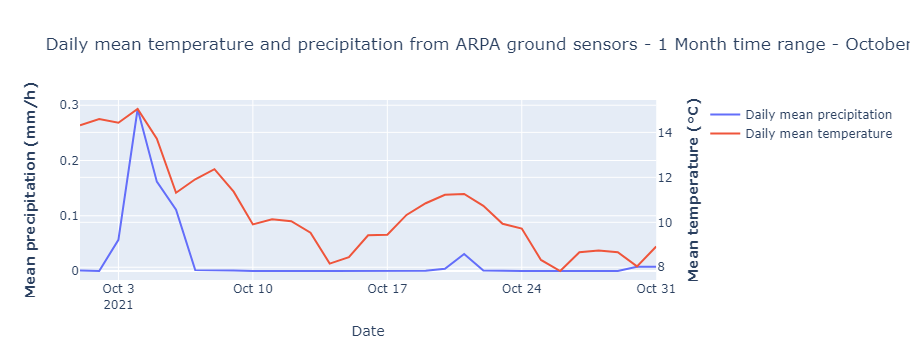

In [29]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=prec_mean.index, y=prec_mean.valore, name="Daily mean precipitation"),
    secondary_y=False)

fig.add_trace(
    go.Scatter(x=temp_mean.index, y=temp_mean.valore, name="Daily mean temperature"),
    secondary_y=True)

# Add figure title
fig.update_layout(
    title_text="Daily mean temperature and precipitation from ARPA ground sensors - 1 Month time range - " +str(start_date_dt.strftime("%B %Y")))

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Mean precipitation (mm/h)</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Mean temperature (°C)</b>", secondary_y=True)

fig.show()

----

# TEST

Could be used for longer time ranges. With 1 month is better to use graph maybe

In [18]:
prec_mean['roll'] = prec_mean['valore'].rolling(7).mean()
temp_mean['roll'] = temp_mean['valore'].rolling(7).mean()

In [19]:
prec_mean_min = prec_mean['roll'].min()
temp_mean_max = temp_mean['roll'].max()

In [20]:
final_prec = prec_mean.loc[prec_mean['roll'] == prec_mean_min]
final_temp = temp_mean.loc[temp_mean['roll'] == temp_mean_max]

In [21]:
print('Least raining period: ' + str(final_prec.index[0]-timedelta(days=6))[0:10], 'to '+ str(final_prec.index[0])[0:10])
print('Highest temperature period: ' + str(final_temp.index[0]-timedelta(days=6))[0:10], 'to '+ str(final_temp.index[0])[0:10])

Least raining period: 2021-10-23 to 2021-10-29
Highest temperature period: 2021-10-01 to 2021-10-07


In [22]:
prec_mean

,valore,data,roll
data,,,
2021-10-01,0.000903,2021-10-01,NaN
2021-10-02,0.000141,2021-10-02,NaN
2021-10-03,0.056299,2021-10-03,NaN
2021-10-04,0.293202,2021-10-04,NaN
2021-10-05,0.161710,2021-10-05,NaN
2021-10-06,0.110859,2021-10-06,NaN
2021-10-07,0.001851,2021-10-07,0.089281
2021-10-08,0.001820,2021-10-08,0.089412
2021-10-09,0.000749,2021-10-09,0.089498


In [23]:
temp_mean

,valore,zscore,data,roll
data,,,,
2021-10-01,14.318764,1.027626,2021-10-01,NaN
2021-10-02,14.596692,1.060353,2021-10-02,NaN
2021-10-03,14.428155,0.996188,2021-10-03,NaN
2021-10-04,15.039729,1.066024,2021-10-04,NaN
2021-10-05,13.722063,0.960576,2021-10-05,NaN
2021-10-06,11.313795,0.824679,2021-10-06,NaN
2021-10-07,11.912955,0.890863,2021-10-07,13.618879
2021-10-08,12.364194,0.807252,2021-10-08,13.339655
2021-10-09,11.364343,0.809111,2021-10-09,12.877890
